In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\pourt\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Statistiques descriptives

En première analyse et afin de se familiariser avec les données obtenues avec le datascraping, nous allons faire quelques statistiques descriptives sur notre base de données

# Répartition des questions par groupe politique

Pour débuter, nous allons nous interesser à la proportion de questions aux gouvernements écrites en fonction de l'appartenance à un groupe politique




In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dict_values(dictionary):
    """
    Crée un diagramme à barres des valeurs d'un dictionnaire.

    Args:
    - dictionary (dict): Un dictionnaire dont les clés sont d'un type quelconque et les valeurs sont des entiers.

    Returns:
    - None
    """
    total = sum(dictionary.values())
    keys = list(dictionary.keys())
    values = [value / total * 100 for value in dictionary.values()]

    colors = plt.cm.viridis(np.linspace(0, 1, len(keys)))

    plt.bar(keys, values, color=colors)
    plt.xlabel('Clés')
    plt.ylabel('Valeurs')
    plt.title('Diagramme des valeurs du dictionnaire')
    plt.show()

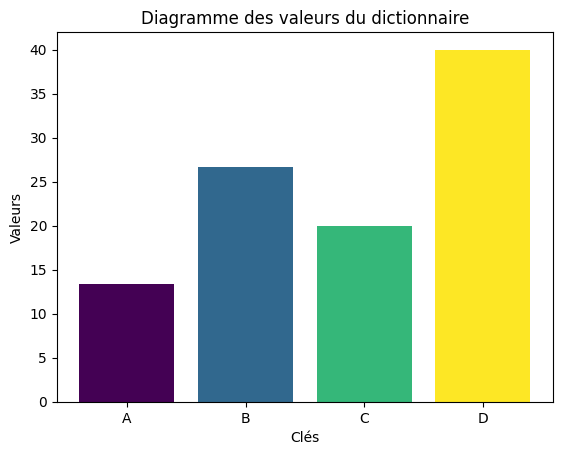

In [13]:
mon_dictionnaire = {'A': 10, 'B': 20, 'C': 15, 'D': 30}
plot_dict_values(mon_dictionnaire)